In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("C:\\Program Files\\DIgSILENT\\PowerFactory 2024 SP4A\\Python\\3.12")
import powerfactory as pf

PFapp: pf.Application = pf.GetApplicationExt()
PFapp.Show()

from admittance_matrix.utils import init_project
init_project(PFapp, "SLO_EES_2024_projekt_SSSC")

True

In [ ]:
# from admittance_matrix.utils import obtain_rms_results
# files_path = "C:\\Projects\\PFAdmittanceMatrix\\busbar_testing\\rms_results\\2022_dan_LF_reduced_WITHSOURCES"
# PFapp.Hide()
# obtain_rms_results(PFapp, files_path, "Izvoz RoCof Martin")
# PFapp.Show()

In [155]:
from admittance_matrix import Network
PFapp.Hide()
# Initialize network from PowerFactory
net = Network(PFapp, base_mva=100.0)
PFapp.Show()
print(f"Network Summary:")
print(f"  Buses: {net.n_buses}")
print(f"  Generators: {net.n_generators}")
print(f"  Loads: {net.n_loads}")
print(f"  Lines: {net.n_lines}")
print(f"  Transformers: {net.n_transformers}")
print(f"  Voltage Sources: {net.n_voltage_sources}")
print(f"  External Grids: {net.n_external_grids}")

[WARNING] Switch 'IS0.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS1.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS10.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS11.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS12.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS13.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS14.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS15.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS16.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS17.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS18.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS2.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS3.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS4.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS5.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS6.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS7.3': Bus(es) de-energized, skipping
[WARNING] Switch 'IS8.

In [156]:
# Build matrices, run load flow, and reduce to generators in one workflow
PFapp.Hide()
net.build_matrices() # Obtain LoadFlow admittance matrix and Stability admittance matrix
PFapp.Show()

# # Run network diagnostics to identify potential issues (islands, singular matrices, etc.)
# diag = net.diagnose(print_results=True)

# # Show the islands if any
# if diag['has_islands']:
#     print("\n⚠️  DETAILED ISLAND INFO:")
#     for i, island in enumerate(diag['islands']):
#         print(f"\nIsland {i+1} ({len(island)} buses):")
#         for bus in sorted(island):
#             print(f"    {bus}")

In [157]:
# Now apply code to calculate synchronizing power coefficients and power distribution ratios
PFapp.Hide()
net.run_load_flow()
net.reduce_to_generators(include_voltage_sources=True)

118
Number of generators extracted: 107
Number of voltage sources extracted: 5
Source reduction summary:
  Generators: 107
  Voltage Sources: 5
  External Grids: 0
  Total sources: 112
118
Number of generators extracted: 107
Number of voltage sources extracted: 5
Source reduction summary:
  Generators: 107
  Voltage Sources: 5
  External Grids: 0
  Total sources: 112


In [158]:
# Calculate power distribution ratios (returns ratios and matching gen names)
DIST_GEN = "NEK"  # <-- Enter generator name here
ratios, gen_names_order, sources_types = net.calculate_power_ratios(DIST_GEN)
print(sources_types)
# gen_names_order = gen_names_order[:-5]
# ratios = ratios[:-5]
PFapp.Show()

['generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator', 'generator'

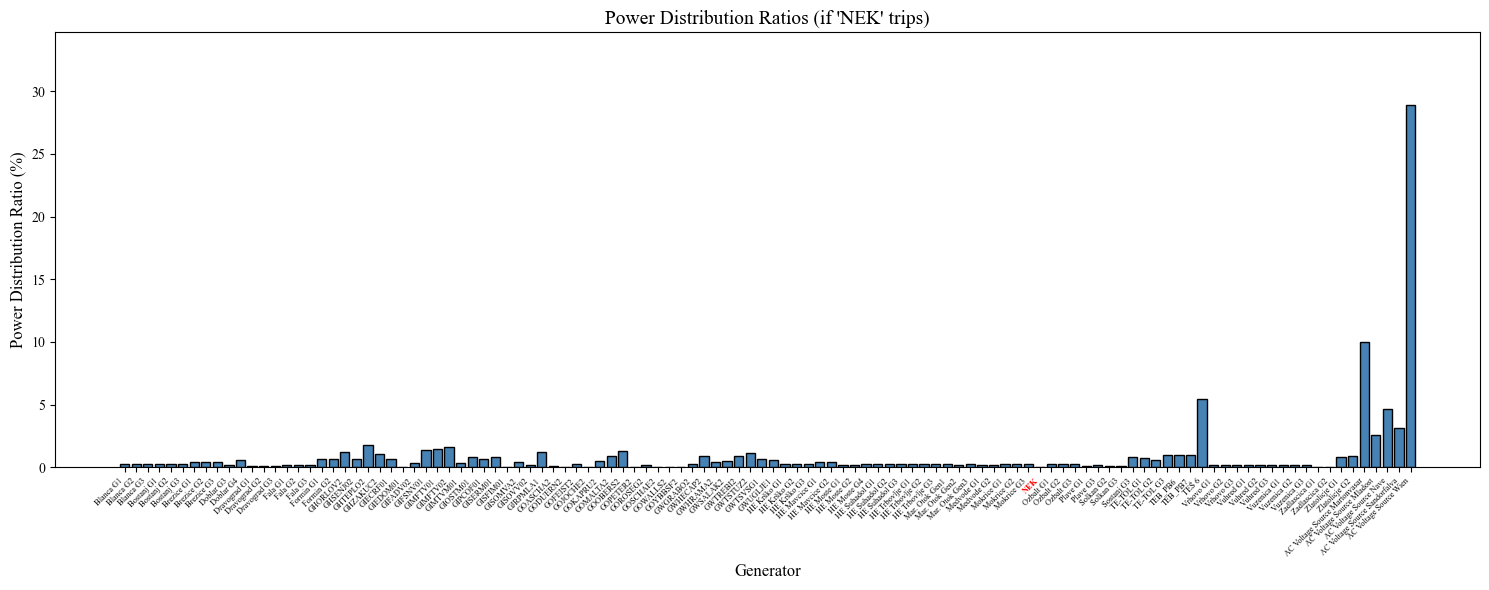

In [159]:
import matplotlib.pyplot as plt

# Create bar chart of power distribution ratios
fig, ax = plt.subplots(figsize=(15, 6))

bars = ax.bar(gen_names_order, ratios * 100, color='steelblue', edgecolor='black')

ax.set_xlabel('Generator', fontsize=12)
ax.set_ylabel('Power Distribution Ratio (%)', fontsize=12)
ax.set_title(f"Power Distribution Ratios (if '{DIST_GEN}' trips)", fontsize=14)
ax.set_ylim(0, max(ratios * 100) * 1.2 if max(ratios) > 0 else 10)

# Color the tripped generator label in red
plt.xticks(rotation=45, ha='right', fontsize=6)
for label in ax.get_xticklabels():
    if label.get_text() == DIST_GEN:
        label.set_color('red')
        label.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [185]:
from admittance_matrix.utils import get_simulation_data
import numpy as np

AVAILABLE_MEASUREMENTS = gen_names_order.copy() # ALL generators have measurements in this case

# # With these available measuyrements (N = 18) zone detection is 100%
# AVAILABLE_MEASUREMENTS = [
#     # "GIMFTV01", # ITALY
#     # "GIFSNV01", # ITALY
#     # "GOPETER2", # AUSTRIA
#     # "GOASCHA2", # AUSTRIA
#     # "GWTSVSG1", # JUG
#     # "GHSENJ02", # JUG

#     # SLOVENIA
#     "TEB_PB6",
#     "TEB_PB7",
#     "Zlatolicje G1",
#     "Zlatolicje G2",
#     "Bostanj G3",
#     "Brezice G1",
#     "HE Trbovlje G2",
#     "HE Moste G1",
#     "Solkan G3",
#     "Vrhovo G2",
#     "NEK",
#     "TEŠ 6",
#     # "Dravograd G1", "Dravograd G2", "Dravograd G3", "Vuzenica G1", "Vuzenica G2", "Vuzenica G3",
# ]

# Filter out measurements that don't exist in gen_order
not_in_gen_order = [gen for gen in AVAILABLE_MEASUREMENTS if gen not in gen_names_order]
if not_in_gen_order:
    print(f"Generators not in gen_order (removed): {not_in_gen_order}")
    AVAILABLE_MEASUREMENTS = [gen for gen in AVAILABLE_MEASUREMENTS if gen in gen_names_order]

# Get the simulation data
RMS_RESULTS_PATH = "./rms_results/2022_dan_LF_reduced_WITHSOURCES/"
rdP, simulation_gen_order, data = get_simulation_data(DIST_GEN, f"{RMS_RESULTS_PATH}results_izpad_{DIST_GEN}.csv", AVAILABLE_MEASUREMENTS, "Izvoz RoCof Martin")

# Reorder rdP to match gen_order
rdP_reordered = np.array([rdP[simulation_gen_order.index(gen)] if gen in simulation_gen_order else np.nan for gen in gen_names_order])

Original lengths - rdP_reordered: 112, ratios: 112
Filtered lengths - generators: 112, rdP: 112, ratios: 112
Available measurements: ['Blanca G1', 'Blanca G2', 'Blanca G3', 'Bostanj G1', 'Bostanj G2', 'Bostanj G3', 'Brezice G1', 'Brezice G2', 'Brezice G3', 'Doblar G3', 'Doblar G4', 'Dravograd G1', 'Dravograd G2', 'Dravograd G3', 'Fala G1', 'Fala G2', 'Fala G3', 'Formin G1', 'Formin G2', 'GHORLOV2', 'GHSENJ02', 'GHTEPLO2', 'GHZAKUC2', 'GIECRF01', 'GIEDOM01', 'GIFADV02', 'GIFSNV01', 'GIMFTV01', 'GIMFTV02', 'GIMTVM01', 'GIOSTM01', 'GIPCOF01', 'GISERM01', 'GISFIM01', 'GISOMVA2', 'GISOVV02', 'GJRPMLA1', 'GOASCHA2', 'GODUERN2', 'GOFEIST2', 'GOJOCHE2', 'GOKAPRU2', 'GOMALTA2', 'GOOBERS2', 'GOPETER2', 'GOROSEG2', 'GOSCHAE2', 'GOWALLS2', 'GOYBBSF2', 'GWGRABO2', 'GWHECAP2', 'GWHRAMA2', 'GWSALAK2', 'GWTREBI2', 'GWTSTUZ2', 'GWTSVSG1', 'GWUGLJE1', 'HE Krško G1', 'HE Krško G2', 'HE Krško G3', 'HE Mavcice G1', 'HE Mavcice G2', 'HE Moste G1', 'HE Moste G2', 'HE Moste G4', 'HE Suhadol G1', 'HE Suhadol G

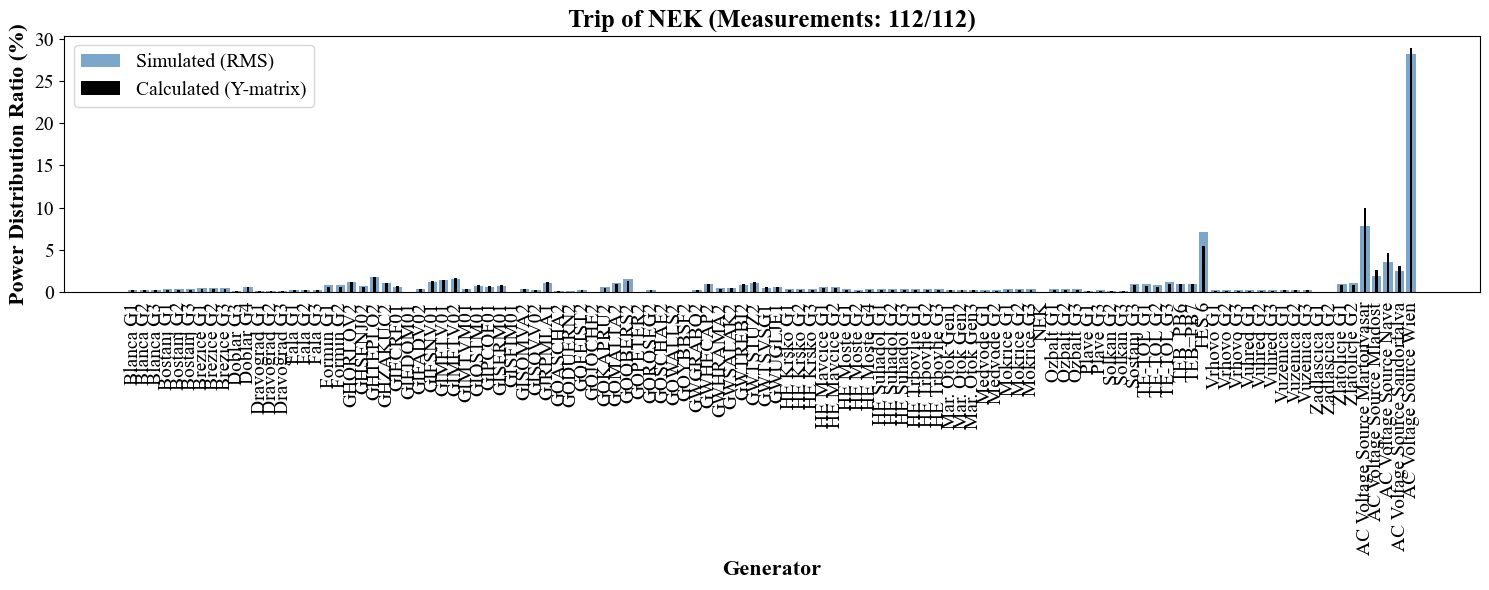


=== Comparison Statistics ===
Mean absolute error: 0.12%
Max absolute error: 2.15%
Correlation coefficient: 0.9950


In [186]:
# Plot the synched_simulation_data values
import matplotlib.pyplot as plt

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['svg.fonttype'] = 'none'  # Embed fonts as text, not paths

print(f"Original lengths - rdP_reordered: {len(rdP_reordered)}, ratios: {len(ratios)}")

# Filter to only include available measurements (non-NaN values)
# Create mask for available measurements
available_mask = ~np.isnan(rdP_reordered)
available_indices = np.where(available_mask)[0]

# Filter generator names, rdP, and ratios to only available measurements
generator_names_filtered = [gen_names_order[i] for i in available_indices]
rdP_filtered = rdP_reordered[available_mask]
ratios_filtered = np.array([ratios[i] for i in available_indices])

print(f"Filtered lengths - generators: {len(generator_names_filtered)}, rdP: {len(rdP_filtered)}, ratios: {len(ratios_filtered)}")
print(f"Available measurements: {generator_names_filtered}")

# Renormalize both to sum to 100%
rdP_sum = np.sum(rdP_filtered)
ratios_sum = np.sum(ratios_filtered)

rdP_normalized = (rdP_filtered / rdP_sum) * 100 if rdP_sum > 0 else rdP_filtered
ratios_normalized = (ratios_filtered / ratios_sum) * 100 if ratios_sum > 0 else ratios_filtered

# Plot only available measurements (renormalized)
plt.figure(figsize=(15, 6))
bar2 = plt.bar(generator_names_filtered, rdP_normalized, 0.8, color='steelblue', label='Simulated (RMS)', alpha=0.7)
bar1 = plt.bar(generator_names_filtered, ratios_normalized, 0.25, color='black', label='Calculated (Y-matrix)', alpha=1)
plt.xlabel('Generator', fontsize=16, fontweight='bold')
plt.ylabel('Power Distribution Ratio (%)', fontsize=16, fontweight='bold')
plt.title(f'Trip of {DIST_GEN} (Measurements: {len(generator_names_filtered)}/{len(gen_names_order)})', 
          fontsize=18, fontweight='bold')
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.grid(False)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\n=== Comparison Statistics ===")
print(f"Mean absolute error: {np.mean(np.abs(rdP_normalized - ratios_normalized)):.2f}%")
print(f"Max absolute error: {np.max(np.abs(rdP_normalized - ratios_normalized)):.2f}%")
print(f"Correlation coefficient: {np.corrcoef(rdP_normalized, ratios_normalized)[0,1]:.4f}")

Original lengths - rdP_reordered: 112, ratios: 112
Filtered lengths - generators: 112, rdP: 112, ratios: 112


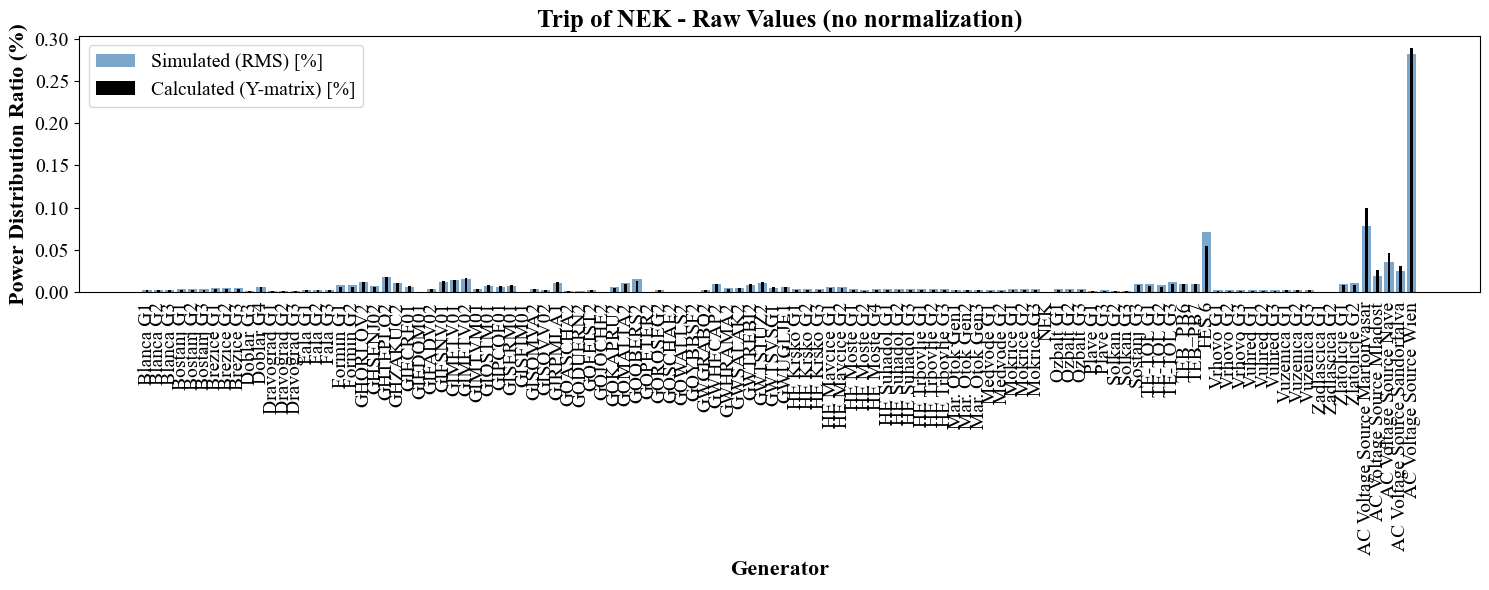

In [187]:
# Plot raw simulation data vs calculated ratios (no normalization)
import matplotlib.pyplot as plt
import numpy as np

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['svg.fonttype'] = 'none'

print(f"Original lengths - rdP_reordered: {len(rdP_reordered)}, ratios: {len(ratios)}")

# Filter to only include available measurements (non-NaN values)
available_mask = ~np.isnan(rdP_reordered)
available_indices = np.where(available_mask)[0]

# Filter to available measurements only
generator_names_filtered = [gen_names_order[i] for i in available_indices]
rdP_filtered = rdP_reordered[available_mask]
ratios_filtered = np.array([ratios[i] for i in available_indices])

print(f"Filtered lengths - generators: {len(generator_names_filtered)}, rdP: {len(rdP_filtered)}, ratios: {len(ratios_filtered)}")

# Convert ratios to percentage for comparison (rdP is already in %)
ratios_percent = ratios_filtered

# Plot raw values
plt.figure(figsize=(15, 6))
bar2 = plt.bar(generator_names_filtered, rdP_filtered, 0.8, color='steelblue', label='Simulated (RMS) [%]', alpha=0.7)
bar1 = plt.bar(generator_names_filtered, ratios_percent, 0.25, color='black', label='Calculated (Y-matrix) [%]', alpha=1)
plt.xlabel('Generator', fontsize=16, fontweight='bold')
plt.ylabel('Power Distribution Ratio (%)', fontsize=16, fontweight='bold')
plt.title(f'Trip of {DIST_GEN} - Raw Values (no normalization)', fontsize=18, fontweight='bold')
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.grid(False)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


Ratios matrix shape: (107, 112)
  Rows (outages): 107
  Columns (sources): 112

Filtered matrix (generators only): (107, 107)
  Removed 5 voltage sources
Filtered matrix (available measurements only): (107, 107)
  Using 107 measurements: ['Blanca G1', 'Blanca G2', 'Blanca G3', 'Bostanj G1', 'Bostanj G2', 'Bostanj G3', 'Brezice G1', 'Brezice G2', 'Brezice G3', 'Doblar G3', 'Doblar G4', 'Dravograd G1', 'Dravograd G2', 'Dravograd G3', 'Fala G1', 'Fala G2', 'Fala G3', 'Formin G1', 'Formin G2', 'GHORLOV2', 'GHSENJ02', 'GHTEPLO2', 'GHZAKUC2', 'GIECRF01', 'GIEDOM01', 'GIFADV02', 'GIFSNV01', 'GIMFTV01', 'GIMFTV02', 'GIMTVM01', 'GIOSTM01', 'GIPCOF01', 'GISERM01', 'GISFIM01', 'GISOMVA2', 'GISOVV02', 'GJRPMLA1', 'GOASCHA2', 'GODUERN2', 'GOFEIST2', 'GOJOCHE2', 'GOKAPRU2', 'GOMALTA2', 'GOOBERS2', 'GOPETER2', 'GOROSEG2', 'GOSCHAE2', 'GOWALLS2', 'GOYBBSF2', 'GWGRABO2', 'GWHECAP2', 'GWHRAMA2', 'GWSALAK2', 'GWTREBI2', 'GWTSTUZ2', 'GWTSVSG1', 'GWUGLJE1', 'HE Krško G1', 'HE Krško G2', 'HE Krško G3', 'HE

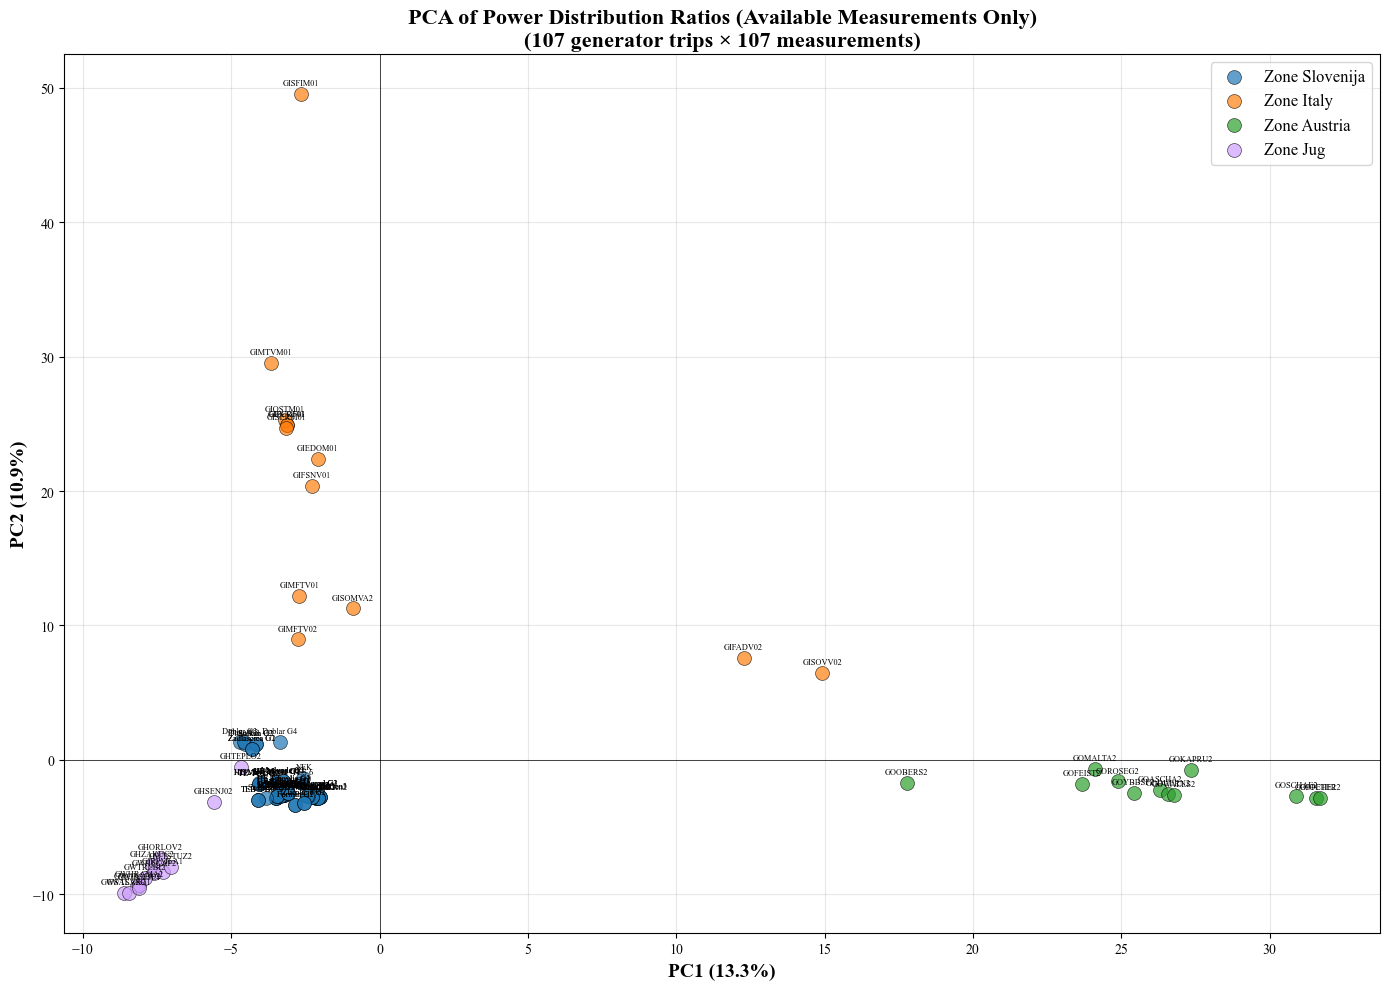

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['svg.fonttype'] = 'none'

# Define colors for each zone (hardcoded zone names)
zone_colors = {
    'Zone Slovenija': '#1f77b4',  # Blue
    'Zone Italy': '#ff7f0e',       # Orange
    'Zone Austria': '#2ca02c',     # Green
    'Zone Jug': '#CF9FFF',         # Purple
    'Unknown': '#808080'           # Gray for unknown zones
}

# Calculate power distribution ratios matrix for all generator outages
ratios_matrix, outage_names, source_names, source_types = net.calculate_all_power_ratios(
    normalize=True,
    verbose=True
)

# Filter out voltage sources - keep only generators as columns
generator_mask = np.array([t == 'generator' for t in source_types])
ratios_matrix_gen = ratios_matrix[:, generator_mask]
source_names_gen = [name for name, t in zip(source_names, source_types) if t == 'generator']

print(f"\nFiltered matrix (generators only): {ratios_matrix_gen.shape}")
print(f"  Removed {sum(1 for t in source_types if t == 'voltage_source')} voltage sources")

# Filter to only AVAILABLE_MEASUREMENTS (columns)
available_mask = np.array([name in AVAILABLE_MEASUREMENTS for name in source_names_gen])
ratios_matrix_available = ratios_matrix_gen[:, available_mask]
source_names_available = [name for name in source_names_gen if name in AVAILABLE_MEASUREMENTS]

print(f"Filtered matrix (available measurements only): {ratios_matrix_available.shape}")
print(f"  Using {len(source_names_available)} measurements: {source_names_available}")

# Re-normalize rows to sum to 100% after filtering
ratios_matrix_normalized = np.zeros_like(ratios_matrix_available)
for i in range(ratios_matrix_available.shape[0]):
    row_sum = np.sum(ratios_matrix_available[i, :])
    if row_sum > 0:
        ratios_matrix_normalized[i, :] = (ratios_matrix_available[i, :] / row_sum) * 100
    else:
        ratios_matrix_normalized[i, :] = ratios_matrix_available[i, :]

# Get zones for all outage generators
outage_zones = [net.get_zone(gen) for gen in outage_names]
unique_zones = list(set(outage_zones))
print(f"Unique zones: {unique_zones}")

# Perform PCA on filtered matrix
pca = PCA(n_components=2)
ratios_pca = pca.fit_transform(ratios_matrix_normalized)

print(f"\nPCA Explained Variance Ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Plot PCA results
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot with zone colors
for zone in zone_colors.keys():
    mask = [z == zone for z in outage_zones]
    if any(mask):
        idx = [i for i, m in enumerate(mask) if m]
        ax.scatter(ratios_pca[idx, 0], ratios_pca[idx, 1], 
                   c=zone_colors[zone], label=zone,
                   s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

# Add labels for each point
for i, gen_name in enumerate(outage_names):
    ax.annotate(gen_name, (ratios_pca[i, 0], ratios_pca[i, 1]), 
                fontsize=6, ha='center', va='bottom', 
                xytext=(0, 5), textcoords='offset points')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=14, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=14, fontweight='bold')
ax.set_title(f'PCA of Power Distribution Ratios (Available Measurements Only)\n({ratios_matrix_normalized.shape[0]} generator trips × {ratios_matrix_normalized.shape[1]} measurements)', 
             fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


Ratios matrix shape: (107, 112)
  Rows (outages): 107
  Columns (sources): 112

Filtered matrix (generators only): (107, 107)
  Removed 5 voltage sources
Unique zones: ['Zone Austria', 'Zone Italy', 'Zone Slovenija', 'Zone Jug']

PCA Explained Variance Ratio:
  PC1: 13.32%
  PC2: 10.85%
  Total: 24.17%


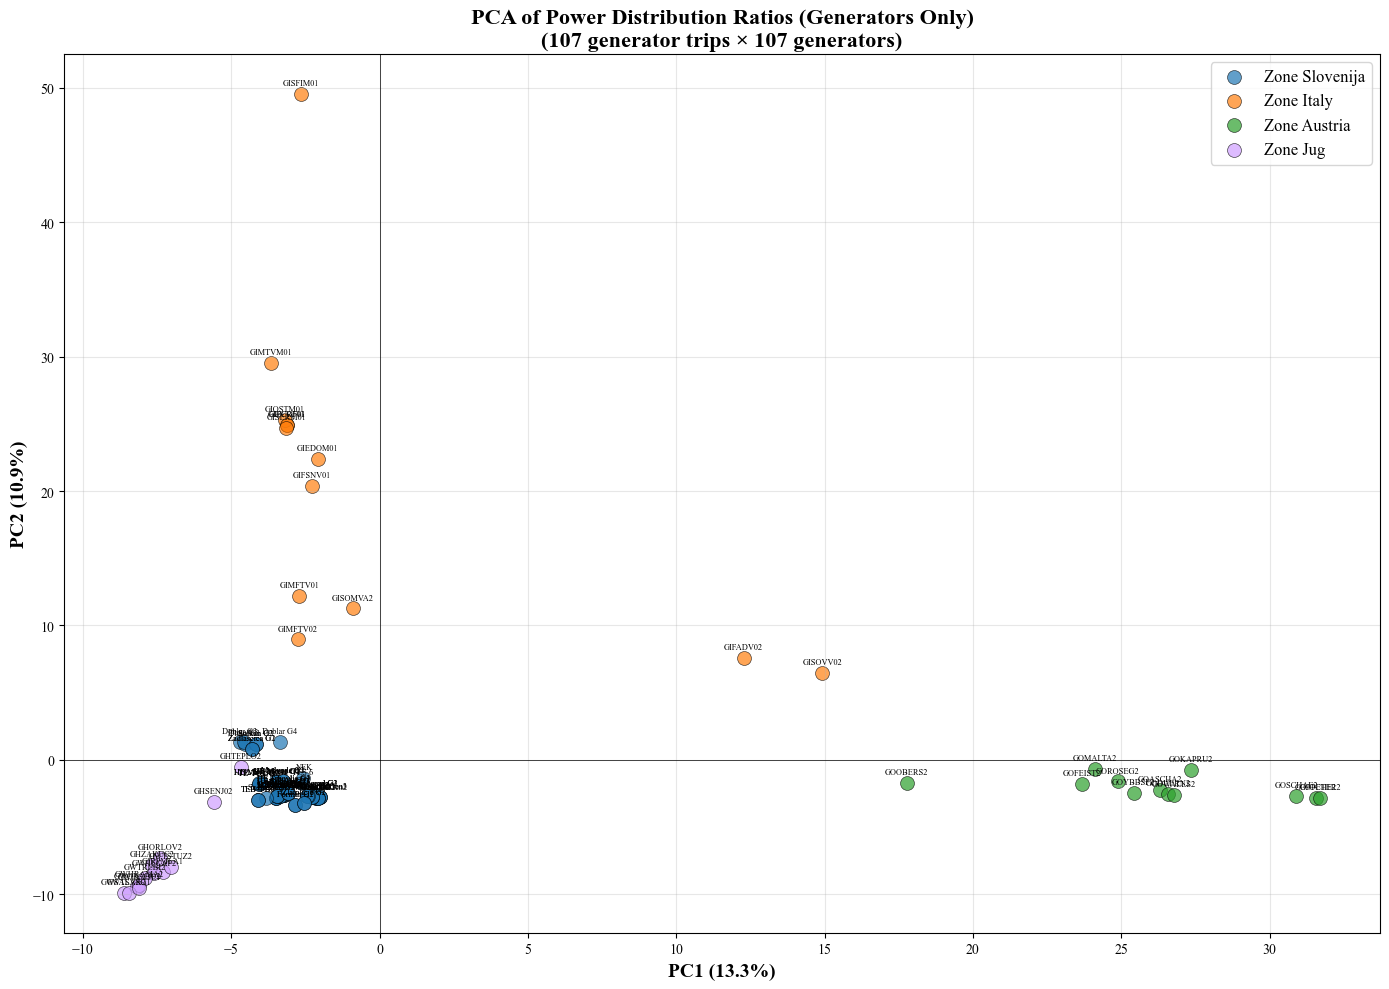

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['svg.fonttype'] = 'none'

# Define colors for each zone (hardcoded zone names)
zone_colors = {
    'Zone Slovenija': '#1f77b4',  # Blue
    'Zone Italy': '#ff7f0e',       # Orange
    'Zone Austria': '#2ca02c',     # Green
    'Zone Jug': '#CF9FFF',         # Purple
    'Unknown': '#808080'           # Gray for unknown zones
}

# Calculate power distribution ratios matrix for all generator outages
ratios_matrix, outage_names, source_names, source_types = net.calculate_all_power_ratios(
    normalize=True,
    verbose=True
)

# Filter out voltage sources - keep only generators as columns
generator_mask = np.array([t == 'generator' for t in source_types])
ratios_matrix_gen_only = ratios_matrix[:, generator_mask]
source_names_gen_only = [name for name, t in zip(source_names, source_types) if t == 'generator']

print(f"\nFiltered matrix (generators only): {ratios_matrix_gen_only.shape}")
print(f"  Removed {sum(1 for t in source_types if t == 'voltage_source')} voltage sources")

# Re-normalize rows to sum to 100% after filtering
ratios_matrix_normalized = np.zeros_like(ratios_matrix_gen_only)
for i in range(ratios_matrix_gen_only.shape[0]):
    row_sum = np.sum(ratios_matrix_gen_only[i, :])
    if row_sum > 0:
        ratios_matrix_normalized[i, :] = (ratios_matrix_gen_only[i, :] / row_sum) * 100
    else:
        ratios_matrix_normalized[i, :] = ratios_matrix_gen_only[i, :]

# Get zones for all outage generators
outage_zones = [net.get_zone(gen) for gen in outage_names]
unique_zones = list(set(outage_zones))
print(f"Unique zones: {unique_zones}")

# Perform PCA on generator-only matrix
pca = PCA(n_components=2)
ratios_pca = pca.fit_transform(ratios_matrix_normalized)

print(f"\nPCA Explained Variance Ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Plot PCA results
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot with zone colors
for zone in zone_colors.keys():
    mask = [z == zone for z in outage_zones]
    if any(mask):
        idx = [i for i, m in enumerate(mask) if m]
        ax.scatter(ratios_pca[idx, 0], ratios_pca[idx, 1], 
                   c=zone_colors[zone], label=zone,
                   s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

# Add labels for each point
for i, gen_name in enumerate(outage_names):
    ax.annotate(gen_name, (ratios_pca[i, 0], ratios_pca[i, 1]), 
                fontsize=6, ha='center', va='bottom', 
                xytext=(0, 5), textcoords='offset points')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=14, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=14, fontweight='bold')
ax.set_title(f'PCA of Power Distribution Ratios (Generators Only)\n({ratios_matrix_normalized.shape[0]} generator trips × {ratios_matrix_normalized.shape[1]} generators)', 
             fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

In [190]:
# PCA-based outage identification using simulation data (Generators Only)
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from admittance_matrix.utils import get_simulation_data

# Configuration
N_PCA_COMPONENTS = 99
MIN_POWER_MW = 5  # Skip generators with pgini < this value
TOP_K = 5  # Number of closest matches for zone voting

# Filter out voltage sources - keep only generators
generator_mask = np.array([t == 'generator' for t in source_types])
ratios_matrix_gen = ratios_matrix[:, generator_mask]
source_names_gen = [name for name, t in zip(source_names, source_types) if t == 'generator']

print(f"Using generator-only matrix: {ratios_matrix_gen.shape}")
print(f"  Excluded {sum(1 for t in source_types if t == 'voltage_source')} voltage sources")

# Results tracking
results = []
total_tests = 0
skipped_tests = 0
correct_gen_matches = 0
correct_zone_matches = 0
correct_zone_matches_softmax = 0
correct_zone_matches_maxsim = 0

print("\nTesting PCA-based outage identification using simulation data...")
print("=" * 100)

for test_gen in outage_names:
    try:
        # Skip generator if power < MIN_POWER_MW
        pf_gens = PFapp.GetCalcRelevantObjects(f"{test_gen}.ElmSym")
        if not pf_gens:
            print(f"{test_gen:15s} → SKIPPED (not found in PowerFactory)")
            skipped_tests += 1
            continue
        
        gen_obj = pf_gens[0]
        if gen_obj.pgini < MIN_POWER_MW:
            skipped_tests += 1
            continue

        # Load simulation data for this generator outage
        # EXCLUDE the test generator from available measurements (it's the one that tripped!)
        _AVAILABLE_MEASUREMENTS = [m for m in AVAILABLE_MEASUREMENTS if m != test_gen]
        
        rdP_test, simulation_gen_order, data_test = get_simulation_data(
            test_gen, 
            f"{RMS_RESULTS_PATH}results_izpad_{test_gen}.csv", 
            _AVAILABLE_MEASUREMENTS,  # Use filtered list (without test_gen)
            "Izvoz RoCof Martin"
        )
        
        # Reorder to match source_names_gen order
        rdP_reordered = np.array([
            rdP_test[simulation_gen_order.index(gen)] if gen in simulation_gen_order else np.nan 
            for gen in source_names_gen
        ])
        
        # Create mask for available measurements
        available_mask = ~np.isnan(rdP_reordered)
        
        # Filter simulation data and ratios matrix to available measurements
        rdP_filtered = rdP_reordered[available_mask]
        ratios_matrix_filtered = ratios_matrix_gen[:, available_mask]
        
        # Normalize ratios_matrix rows to sum to 100%
        ratios_matrix_normalized = np.zeros_like(ratios_matrix_filtered)
        for i in range(ratios_matrix_filtered.shape[0]):
            row_sum = np.sum(ratios_matrix_filtered[i, :])
            if row_sum > 0:
                ratios_matrix_normalized[i, :] = (ratios_matrix_filtered[i, :] / row_sum) * 100
            else:
                ratios_matrix_normalized[i, :] = ratios_matrix_filtered[i, :]
        
        # Normalize simulation data to sum to 100%
        rdP_sum = np.sum(rdP_filtered)
        rdP_normalized = (rdP_filtered / rdP_sum) * 100 if rdP_sum > 0 else rdP_filtered
        
        # Fit PCA on calculated ratios
        n_components = min(N_PCA_COMPONENTS, ratios_matrix_normalized.shape[1] - 1)
        pca_test = PCA(n_components=n_components)
        ratios_pca = pca_test.fit_transform(ratios_matrix_normalized)
        
        # Transform simulation data to PCA space
        rdP_pca = pca_test.transform(rdP_normalized.reshape(1, -1))
        
        # Calculate distances to all patterns in PCA space
        distances = np.sqrt(np.sum((ratios_pca - rdP_pca)**2, axis=1))
        
        # Find closest match (generator-based)
        closest_idx = np.argmin(distances)
        predicted_gen = outage_names[closest_idx]
        
        # Get zones for actual and predicted generators
        actual_zone = net.get_zone(test_gen)
        predicted_zone = net.get_zone(predicted_gen)
        
        # Check matches
        gen_match = (predicted_gen == test_gen)
        zone_match = (predicted_zone == actual_zone)
        
        # ===== ZONE-LEVEL PREDICTIONS WITH SOFTMAX =====
        top_k_indices = np.argsort(distances)[:TOP_K]
        top_k_distances = distances[top_k_indices]
        top_k_generators = [outage_names[idx] for idx in top_k_indices]
        
        # Convert distances to similarities
        similarities = 1.0 / (1.0 + top_k_distances)
        
        # Softmax for probability distribution
        exp_sim = np.exp(similarities * 10)
        probabilities = exp_sim / np.sum(exp_sim)
        
        # APPROACH 1: Softmax Probability Aggregation
        zone_probabilities = {}
        for i, gen in enumerate(top_k_generators):
            zone = net.get_zone(gen)
            zone_probabilities[zone] = zone_probabilities.get(zone, 0.0) + probabilities[i]
        
        predicted_zone_softmax = max(zone_probabilities, key=zone_probabilities.get)
        zone_match_softmax = (predicted_zone_softmax == actual_zone)
        
        # APPROACH 2: Max Similarity per Zone
        zone_max_similarities = {}
        for i, gen in enumerate(top_k_generators):
            zone = net.get_zone(gen)
            if zone not in zone_max_similarities or similarities[i] > zone_max_similarities[zone]:
                zone_max_similarities[zone] = similarities[i]
        
        predicted_zone_maxsim = max(zone_max_similarities, key=zone_max_similarities.get)
        zone_match_maxsim = (predicted_zone_maxsim == actual_zone)
        
        # Store results
        results.append({
            'actual_gen': test_gen,
            'predicted_gen': predicted_gen,
            'actual_zone': actual_zone,
            'predicted_zone': predicted_zone,
            'predicted_zone_softmax': predicted_zone_softmax,
            'predicted_zone_maxsim': predicted_zone_maxsim,
            'distance': distances[closest_idx],
            'gen_match': gen_match,
            'zone_match': zone_match,
            'zone_match_softmax': zone_match_softmax,
            'zone_match_maxsim': zone_match_maxsim,
        })
        
        if gen_match:
            correct_gen_matches += 1
        if zone_match:
            correct_zone_matches += 1
        if zone_match_softmax:
            correct_zone_matches_softmax += 1
        if zone_match_maxsim:
            correct_zone_matches_maxsim += 1
        total_tests += 1
        
        # Print only if at least one zone prediction method fails
        if not zone_match or not zone_match_softmax or not zone_match_maxsim:
            gen_symbol = "✓" if gen_match else "✗"
            zone_symbol = "✓" if zone_match else "✗"
            zone_softmax_symbol = "✓" if zone_match_softmax else "✗"
            zone_maxsim_symbol = "✓" if zone_match_maxsim else "✗"
            print(f"{test_gen:15s} [{actual_zone:15s}] → Pred:{predicted_gen:15s} Gen:{gen_symbol} | Zone-NN:{zone_symbol} Softmax:[{predicted_zone_softmax:15s}]{zone_softmax_symbol} MaxSim:{zone_maxsim_symbol}")
        
    except Exception as e:
        print(f"{test_gen:15s} → SKIPPED ({str(e)[:60]}...)")
        skipped_tests += 1
        continue

print("=" * 100)

# Create summary DataFrame
results_df = pd.DataFrame(results)

# Print summary
print(f"\n=== PCA-BASED OUTAGE IDENTIFICATION SUMMARY (Generators Only) ===")
print(f"Total tests: {total_tests}")
print(f"Skipped tests: {skipped_tests}")
print(f"\nGenerator exact matches: {correct_gen_matches}/{total_tests} ({correct_gen_matches/total_tests*100:.2f}%)")
print(f"\nZone Prediction Methods:")
print(f"  1. Nearest Neighbor:        {correct_zone_matches}/{total_tests} ({correct_zone_matches/total_tests*100:.2f}%)")
print(f"  2. Softmax Aggregation:     {correct_zone_matches_softmax}/{total_tests} ({correct_zone_matches_softmax/total_tests*100:.2f}%)")
print(f"  3. Max Similarity per Zone: {correct_zone_matches_maxsim}/{total_tests} ({correct_zone_matches_maxsim/total_tests*100:.2f}%)")

# Find best method
best_method = max([
    ('Nearest Neighbor', correct_zone_matches),
    ('Softmax Aggregation', correct_zone_matches_softmax),
    ('Max Similarity', correct_zone_matches_maxsim),
], key=lambda x: x[1])

print(f"\n🏆 Best zone prediction method: {best_method[0]} with {best_method[1]}/{total_tests} ({best_method[1]/total_tests*100:.2f}%) accuracy")

Using generator-only matrix: (107, 107)
  Excluded 5 voltage sources

Testing PCA-based outage identification using simulation data...

=== PCA-BASED OUTAGE IDENTIFICATION SUMMARY (Generators Only) ===
Total tests: 101
Skipped tests: 6

Generator exact matches: 101/101 (100.00%)

Zone Prediction Methods:
  1. Nearest Neighbor:        101/101 (100.00%)
  2. Softmax Aggregation:     101/101 (100.00%)
  3. Max Similarity per Zone: 101/101 (100.00%)

🏆 Best zone prediction method: Nearest Neighbor with 101/101 (100.00%) accuracy

=== PCA-BASED OUTAGE IDENTIFICATION SUMMARY (Generators Only) ===
Total tests: 101
Skipped tests: 6

Generator exact matches: 101/101 (100.00%)

Zone Prediction Methods:
  1. Nearest Neighbor:        101/101 (100.00%)
  2. Softmax Aggregation:     101/101 (100.00%)
  3. Max Similarity per Zone: 101/101 (100.00%)

🏆 Best zone prediction method: Nearest Neighbor with 101/101 (100.00%) accuracy


In [193]:
# === HIERARCHICAL IDENTIFICATION: ZONE -> RIVER GROUP (Generators Only) ===
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from admittance_matrix.utils import get_simulation_data

# Configuration
N_PCA_COMPONENTS = 95
MIN_POWER_MW = 5
TOP_K = 5

# Filter out voltage sources - keep only generators
generator_mask = np.array([t == 'generator' for t in source_types])
ratios_matrix_gen = ratios_matrix[:, generator_mask]
source_names_gen = [name for name, t in zip(source_names, source_types) if t == 'generator']

print(f"Using generator-only matrix: {ratios_matrix_gen.shape}")
print(f"  Excluded {sum(1 for t in source_types if t == 'voltage_source')} voltage sources")

# Additional Groups
GROUP_SOCA = ["Solkan G1", "Solkan G2", "Solkan G3", "Doblar G3", "Doblar G4", "Zadlascica G1", "Zadlascica G2", "Plave G1", "Plave G3"]
GROUP_ZG_SAVA = ["HE Moste G1", "HE Moste G2", "HE Moste G3", "HE Moste G4", "HE Mavcice G1", "HE Mavcice G2", "Medvode G1", "Medvode G2"]
GROUP_SR_SAVA = ["HE Trbovlje G1", "HE Trbovlje G2", "HE Trbovlje G3", "HE Suhadol G1", "HE Suhadol G2", "HE Suhadol G3"]
GROUP_SP_SAVA = ["Vrhovo G1", "Vrhovo G2", "Vrhovo G3", "Bostanj G1", "Bostanj G2", "Bostanj G3",
                "Blanca G1", "Blanca G2", "Blanca G3", "HE Krško G1", "HE Krško G2", "HE Krško G3",
                "Brezice G1", "Brezice G2", "Brezice G3", "Mokrice G1", "Mokrice G2", "Mokrice G3"]
GROUP_DRAVA =  [
                "Dravograd G1", "Dravograd G2", "Dravograd G3", "Vuzenica G1", "Vuzenica G2", "Vuzenica G3",
                "Vuhred G1", "Vuhred G2", "Vuhred G3", "Ozbalt G1", "Ozbalt G2", "Ozbalt G3",
                "Fala G1", "Fala G2", "Fala G3", "Mar. Otok Gen1", "Mar. Otok Gen2", "Mar. Otok Gen3",
                "Zlatolicje G1", "Zlatolicje G2", "Formin G1", "Formin G2",
                ]

GROUP_NEK = ["NEK"]
GROUP_TES = ["TEŠ 6"]
GROUP_TEB = ["TEB_PB6", "TEB_PB7"]
# GROUP_TETOL = ["TE-TOL G1", "TE-TOL2", "TE-TOL3"]

# Create group mapping
group_mapping = {}
for g in GROUP_SOCA: group_mapping[g] = "SOCA"
for g in GROUP_ZG_SAVA: group_mapping[g] = "SAVAZG"
for g in GROUP_SR_SAVA: group_mapping[g] = "SAVASR"
for g in GROUP_SP_SAVA: group_mapping[g] = "SAVASP"
for g in GROUP_DRAVA: group_mapping[g] = "DRAVA"
for g in GROUP_TEB: group_mapping[g] = "TEB"
for g in GROUP_TES: group_mapping[g] = "TES"
for g in GROUP_NEK: group_mapping[g] = "NEK"
# for g in GROUP_TETOL: group_mapping[g] = "TETOL"

print("\nRunning Hierarchical Identification (Zone -> River Group)...")
print("=" * 100)

# Results tracking
h_results = []
h_correct_zone = 0
h_correct_group = 0
h_correct_gen = 0
h_total_tests = 0
h_total_group_tests = 0
h_skipped = 0

for test_gen in outage_names:
    try:
        # Skip generator if power < MIN_POWER_MW
        pf_gens = PFapp.GetCalcRelevantObjects(f"{test_gen}.ElmSym")
        if not pf_gens:
            h_skipped += 1
            continue
        
        gen_obj = pf_gens[0]
        if gen_obj.pgini < MIN_POWER_MW:
            h_skipped += 1
            continue

        h_total_tests += 1
        
        # --- 1. Data Preparation (Generators Only) ---
        # EXCLUDE the test generator from available measurements (it's the one that tripped!)
        _AVAILABLE_MEASUREMENTS = [m for m in AVAILABLE_MEASUREMENTS if m != test_gen]

        rdP_test, simulation_gen_order, data_test = get_simulation_data(
            test_gen, 
            f"{RMS_RESULTS_PATH}results_izpad_{test_gen}.csv", 
            _AVAILABLE_MEASUREMENTS,  # Use generator-only list
            "Izvoz RoCof Martin"
        )
        
        # Reorder to match source_names_gen order
        rdP_reordered = np.array([
            rdP_test[simulation_gen_order.index(gen)] if gen in simulation_gen_order else np.nan 
            for gen in source_names_gen
        ])
        
        # Create mask for available measurements
        available_mask = ~np.isnan(rdP_reordered)
        rdP_filtered = rdP_reordered[available_mask]
        ratios_matrix_filtered = ratios_matrix_gen[:, available_mask]
        
        # Normalize ratios_matrix rows to sum to 100%
        ratios_matrix_normalized = np.zeros_like(ratios_matrix_filtered)
        for i in range(ratios_matrix_filtered.shape[0]):
            row_sum = np.sum(ratios_matrix_filtered[i, :])
            if row_sum > 0:
                ratios_matrix_normalized[i, :] = (ratios_matrix_filtered[i, :] / row_sum) * 100
            else:
                ratios_matrix_normalized[i, :] = ratios_matrix_filtered[i, :]
        
        # Normalize simulation data to sum to 100%
        rdP_sum = np.sum(rdP_filtered)
        rdP_normalized = (rdP_filtered / rdP_sum) * 100 if rdP_sum > 0 else rdP_filtered

        # --- 2. PCA & Distance Calculation ---
        n_components = min(N_PCA_COMPONENTS, ratios_matrix_normalized.shape[1] - 1)
        pca_h = PCA(n_components=n_components)
        ratios_pca = pca_h.fit_transform(ratios_matrix_normalized)
        
        rdP_pca = pca_h.transform(rdP_normalized.reshape(1, -1))
        
        # Calculate distances
        dists = np.sqrt(np.sum((ratios_pca - rdP_pca)**2, axis=1))
        
        # Find closest match (generator-based)
        closest_idx = np.argmin(dists)
        predicted_gen_exact = outage_names[closest_idx]
        if predicted_gen_exact == test_gen:
            h_correct_gen += 1

        # --- 3. Zone-Level Prediction (Max Similarity) ---
        top_k_indices = np.argsort(dists)[:TOP_K]
        top_k_distances = dists[top_k_indices]
        top_k_generators = [outage_names[idx] for idx in top_k_indices]
        
        # Convert distances to similarities
        similarities = 1.0 / (1.0 + top_k_distances)
        
        # Max Similarity per Zone
        zone_max_similarities = {}
        for i, gen in enumerate(top_k_generators):
            zone = net.get_zone(gen)
            if zone not in zone_max_similarities or similarities[i] > zone_max_similarities[zone]:
                zone_max_similarities[zone] = similarities[i]
        
        predicted_zone = max(zone_max_similarities, key=zone_max_similarities.get)
        actual_zone = net.get_zone(test_gen)
        
        is_zone_correct = (predicted_zone == actual_zone)
        if is_zone_correct:
            h_correct_zone += 1
        else:
            print(f"ZONE MISMATCH: {test_gen:15s} [Real: {actual_zone}] -> Pred: {predicted_zone}")
            
        # --- 4. Level 2: Group Identification (Conditional) ---
        predicted_group = None
        actual_group = group_mapping.get(test_gen, None)
        is_group_correct = None
        
        # Only attempt group identification if predicted zone is Slovenia
        if predicted_zone == "Zone Slovenija":
            group_max_sim = {
                "SOCA": 0.0, "SAVAZG": 0.0, "SAVASR": 0.0, "SAVASP": 0.0, 
                "DRAVA": 0.0, "TEB": 0.0, "TES": 0.0, "NEK": 0.0,
                # "TETOL": 0.0
            }
            
            # Find max similarity for each group
            for i, gen in enumerate(top_k_generators):
                if gen in group_mapping:
                    g_group = group_mapping[gen]
                    if similarities[i] > group_max_sim[g_group]:
                        group_max_sim[g_group] = similarities[i]
            
            # Predict group with highest max similarity
            predicted_group = max(group_max_sim, key=group_max_sim.get)
            
            # Check accuracy ONLY if the actual generator belongs to a group
            if actual_group is not None:
                h_total_group_tests += 1
                is_group_correct = (predicted_group == actual_group)
                if is_group_correct:
                    h_correct_group += 1
        
        # Store results
        h_results.append({
            'actual_gen': test_gen,
            'predicted_gen': predicted_gen_exact,
            'actual_zone': actual_zone,
            'predicted_zone': predicted_zone,
            'actual_group': actual_group,
            'predicted_group': predicted_group,
            'zone_correct': is_zone_correct,
            'group_correct': is_group_correct,
            'gen_correct': predicted_gen_exact == test_gen,
        })
        
        # Print errors for grouped generators
        if actual_group is not None and (not is_zone_correct or is_group_correct == False):
            print(f"MISMATCH: {test_gen:15s} [Real: {actual_zone}/{actual_group}] -> Pred: {predicted_zone}/{predicted_group}")

    except Exception as e:
        print(f"Error processing {test_gen}: {str(e)[:60]}...")
        h_skipped += 1

print("=" * 100)

# Create results DataFrame
h_results_df = pd.DataFrame(h_results)

# Print summary
print(f"\n=== HIERARCHICAL IDENTIFICATION SUMMARY (Generators Only) ===")
print(f"Total tests: {h_total_tests}")
print(f"Skipped: {h_skipped}")
print(f"\nGenerator Accuracy: {h_correct_gen}/{h_total_tests} ({h_correct_gen/h_total_tests*100:.1f}%)")
print(f"Zone Accuracy:      {h_correct_zone}/{h_total_tests} ({h_correct_zone/h_total_tests*100:.1f}%)")

if h_total_group_tests > 0:
    print(f"Group Accuracy:     {h_correct_group}/{h_total_group_tests} ({h_correct_group/h_total_group_tests*100:.1f}%) (Only for generators in defined groups)")
else:
    print("Group Accuracy: N/A (No tests performed on grouped generators)")

# Show group-level breakdown
if h_total_group_tests > 0:
    print(f"\n=== GROUP-LEVEL BREAKDOWN ===")
    # Filter to only rows with actual groups (not None) and valid group_correct values
    grouped_df = h_results_df[h_results_df['actual_group'].notna() & h_results_df['group_correct'].notna()].copy()
    # Convert group_correct to numeric (True=1, False=0)
    grouped_df['group_correct_num'] = grouped_df['group_correct'].astype(int)
    
    group_stats = grouped_df.groupby('actual_group').agg({
        'group_correct_num': ['sum', 'count']
    })
    group_stats.columns = ['correct', 'total']
    group_stats['accuracy'] = (group_stats['correct'] / group_stats['total'] * 100).round(1)
    print(group_stats.to_string())

Using generator-only matrix: (107, 107)
  Excluded 5 voltage sources

Running Hierarchical Identification (Zone -> River Group)...

=== HIERARCHICAL IDENTIFICATION SUMMARY (Generators Only) ===
Total tests: 101
Skipped: 6

Generator Accuracy: 101/101 (100.0%)
Zone Accuracy:      101/101 (100.0%)
Group Accuracy:     61/61 (100.0%) (Only for generators in defined groups)

=== GROUP-LEVEL BREAKDOWN ===
              correct  total  accuracy
actual_group                          
DRAVA              22     22     100.0
NEK                 1      1     100.0
SAVASP             18     18     100.0
SAVASR              4      4     100.0
SAVAZG              7      7     100.0
SOCA                6      6     100.0
TEB                 2      2     100.0
TES                 1      1     100.0

=== HIERARCHICAL IDENTIFICATION SUMMARY (Generators Only) ===
Total tests: 101
Skipped: 6

Generator Accuracy: 101/101 (100.0%)
Zone Accuracy:      101/101 (100.0%)
Group Accuracy:     61/61 (100.0%) (Only 

In [192]:
# import matplotlib.pyplot as plt
# import networkx as nx

# # Create graph from branches
# G = nx.Graph()

# # Add nodes (buses)
# for bus in net.bus_names:
#     G.add_node(bus)

# # Add edges (branches) with impedance labels
# for b in net.branches:
#     z = b.impedance
#     if z.real != float('inf'):
#         z_label = f"{z.real:.2f}+j{z.imag:.2f}"
#     else:
#         z_label = "open"
#     G.add_edge(b.from_bus_name, b.to_bus_name, label=b.name, branch_type=type(b).__name__)

# # Draw the network
# plt.figure(figsize=(14, 10))
# pos = nx.spring_layout(G, seed=43)

# # Draw nodes
# nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300)
# nx.draw_networkx_labels(G, pos, font_size=6, font_weight='bold')

# # Draw edges with different colors for lines, switches, and transformers
# line_edges = [(u, v) for u, v, d in G.edges(data=True) if d['branch_type'] == 'LineBranch']
# switch_edges = [(u, v) for u, v, d in G.edges(data=True) if d['branch_type'] == 'SwitchBranch']
# trafo_edges = [(u, v) for u, v, d in G.edges(data=True) if d['branch_type'] == 'TransformerBranch']

# nx.draw_networkx_edges(G, pos, edgelist=line_edges, edge_color='black', width=2)
# nx.draw_networkx_edges(G, pos, edgelist=switch_edges, edge_color='red', width=2, style='dashed')
# nx.draw_networkx_edges(G, pos, edgelist=trafo_edges, edge_color='green', width=3)

# # Add legend
# plt.plot([], [], color='black', linewidth=2, label='Lines')
# plt.plot([], [], color='red', linewidth=2, linestyle='dashed', label='Switches')
# plt.plot([], [], color='green', linewidth=3, label='Transformers')
# plt.legend(loc='upper left')

# plt.title("Network Topology")
# plt.axis('off')
# plt.tight_layout()
# plt.show()